In [1]:
using DataFrames, XLSX
using LinearAlgebra
using JuMP
using LightGraphs, SimpleWeightedGraphs
using MathOptInterfaceMosek

┌ Info: Precompiling XLSX [fdbf4ff8-1666-58a4-91e7-1b58723a45e0]
└ @ Base loading.jl:1242


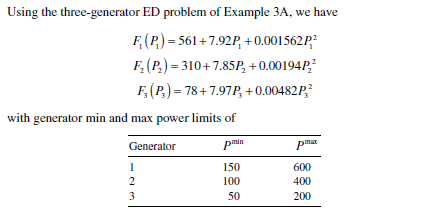

In [11]:
Branch = DataFrame(XLSX.readtable("WSCC System.xlsx", "BranchData", infer_eltypes=true)... )

,Branch,From,To,R,X,B,a,phi,Type
,Int64,Int64,Int64,Float64,Float64,Float64,Float64⍰,Float64⍰,String
1,1,6,4,0.017,0.092,0.158,missing,missing,line
2,2,5,4,0.01,0.085,0.176,missing,missing,line
3,3,7,5,0.032,0.161,0.306,missing,missing,line
4,4,9,6,0.039,0.17,0.358,missing,missing,line
5,5,7,8,0.0085,0.072,0.149,missing,missing,line
6,6,9,8,0.0119,0.1008,0.209,missing,missing,line
7,7,1,4,0.0,0.0576,0.0,1.0,0.0,transf
8,8,2,7,0.0,0.0625,0.0,1.0,0.0,transf
9,9,3,9,0.0,0.0586,0.0,1.0,0.0,transf


In [12]:
Gen = DataFrame(a = [0.001562, 0.00194, 0.00482], 
                b = [7.92, 7.85, 7.97],
                c = [561, 310, 78],
                Pmax = [600, 400, 200],
                Pmin = [150, 100, 50],
                RampUp = [30,20,30],
                RampDown = [30,20,30],
                MinUp = [2,3,2],
                MinDown = [2,3,2]);

9

In [29]:
Bus = max(maximum(Branch.From),maximum(Branch.To))
Gw = SimpleWeightedGraph(Bus)

for i = 1:size(Branch,1)
    add_edge!(Gw,Branch.From[i],Branch.To[i], 1/Branch.X[i])
end

Aw = Array(weights(Gw))
Lw = Diagonal(sum(Aw,dims=1)[:])-Aw
B = Lw;

In [8]:
T = 10

10

In [30]:
B

9×9 Array{Float64,2}:
  17.3611    0.0    0.0     -17.3611  …    0.0        0.0        0.0    
   0.0      16.0    0.0       0.0        -16.0        0.0        0.0    
   0.0       0.0   17.0648    0.0          0.0        0.0      -17.0648 
 -17.3611    0.0    0.0      39.9954       0.0        0.0        0.0    
   0.0       0.0    0.0     -11.7647      -6.21118    0.0        0.0    
   0.0       0.0    0.0     -10.8696  …    0.0        0.0       -5.88235
   0.0     -16.0    0.0       0.0         36.1001   -13.8889     0.0    
   0.0       0.0    0.0       0.0        -13.8889    23.8095    -9.92063
   0.0       0.0  -17.0648    0.0          0.0       -9.92063   32.8678 

In [179]:
rng1 = 180:220; 
rng2 = 520:580; 
rng3 = 80:120;

In [180]:
Load = DataFrame(L1 = rand(rng1,T,) , 
                 L2 = rand(rng2,T,) , 
                 L3 = rand(rng3,T,) )

,L1,L2,L3
,Int64,Int64,Int64
1,216,552,100
2,213,562,84
3,204,525,110
4,184,559,85
5,180,579,88
6,202,550,85
7,188,563,112
8,196,539,107
9,192,565,118


In [181]:
LineLimit = [150, 1000, 1000];

In [240]:
model = nothing

In [241]:
model = Model(with_optimizer(MosekOptimizer, QUIET=false, INTPNT_CO_TOL_DFEAS=1e-7));

In [242]:
@variable(model, P[1:3,1:T])
@variable(model, u[1:3,1:T],Bin)
@variable(model, Us[1:3,1:T],Bin)
@variable(model, Vs[1:3,1:T],Bin)
@variable(model, θ[1:3,1:T])
for t = 1:T 
    fix( θ[1,t], 0, force = true);
end

In [243]:
@objective(model,Min, sum(Gen.a[i]*P[i,j]^2 + Gen.b[i]*P[i,j] + Gen.c[i] for i in 1:3 for j in 1:T));

In [244]:
@constraint(model,LoadBalance[j = 1:T], sum(Load[j,i]   for i in 1:3) == sum(P[i,j] for i in 1:3));

In [245]:
@constraint(model,PowerFlow[i = 1:3, k = 1:T], sum(100 * B[i,j] * (θ[i,k] - θ[j,k]) for j in 1:3) == P[i,k]  - Load[k,i] );

In [246]:
PowerFlow[:,3]

3-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 PowerFlow[1,3] : -1800 θ[1,3] + 1000 θ[2,3] + 800 θ[3,3] - P[1,3] == -204.0
 PowerFlow[2,3] : -1500 θ[2,3] + 1000 θ[1,3] + 500 θ[3,3] - P[2,3] == -525.0
 PowerFlow[3,3] : -1300 θ[3,3] + 800 θ[1,3] + 500 θ[2,3] - P[3,3] == -110.0 

In [247]:
@constraint(model,MaxPowerLimits[i = 1:3,j = 1:T],  P[i,j] <= Gen.Pmax[i]*u[i,j])
@constraint(model,MinPowerLimits[i = 1:3,j = 1:T],  P[i,j] >= Gen.Pmin[i]*u[i,j]);

In [248]:
Gen.RampUp[1]

30

In [249]:
@constraint(model,MaxLineLimit[i = 1:3, k = 1:T],sum(100 * B[i,j] * (θ[i,k] - θ[j,k]) for j in 1:3) <=  LineLimit[i])
@constraint(model,MinLineLimit[i = 1:3, k = 1:T],sum(100 * B[i,j] * (θ[i,k] - θ[j,k]) for j in 1:3) >= -LineLimit[i]);

In [250]:
@constraint(model,RampUpLimit[i = 1:3, j = 2:T], P[i,j] - P[i,j-1] <=  Gen.RampUp[i]*u[i,j])
@constraint(model,RampDownLimit[i = 1:3, j = 2:T], P[i,j-1] - P[i,j] <=  Gen.RampDown[i]*u[i,j]);

In [251]:
@constraint(model,UpStatus[i = 1:3, j = 2:T], u[i,j-1] - u[i,j] + Us[i,j] >=  0 );
@constraint(model,DownStatus[i = 1:3, j = 2:T], u[i,j] - u[i,j-1] + Vs[i,j] >=  0 );
@constraint(model,MinUp[i = 1:3, j = 2:T, k = j+1:min(j+Gen.MinUp[i]-1, T) ], u[i,j] - u[i,j-1]  <=  u[i,k] );
@constraint(model,MinDown[i = 1:3, j = 2:T, k = j+1:min(j+Gen.MinDown[i]-1, T) ], u[i,j-1] - u[i,j]  <=  1 - u[i,k] );

In [252]:
MinUp

JuMP.Containers.SparseAxisArray{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,3,Tuple{Any,Any,Any}} with 31 entries:
  [2, 4, 6 ]  =  MinUp[2,4,6] : u[2,4] - u[2,3] - u[2,6] <= 0.0
  [2, 2, 3 ]  =  MinUp[2,2,3] : u[2,2] - u[2,1] - u[2,3] <= 0.0
  [3, 5, 6 ]  =  MinUp[3,5,6] : u[3,5] - u[3,4] - u[3,6] <= 0.0
  [2, 5, 6 ]  =  MinUp[2,5,6] : u[2,5] - u[2,4] - u[2,6] <= 0.0
  [3, 7, 8 ]  =  MinUp[3,7,8] : u[3,7] - u[3,6] - u[3,8] <= 0.0
  [2, 2, 4 ]  =  MinUp[2,2,4] : u[2,2] - u[2,1] - u[2,4] <= 0.0
  [2, 8, 10]  =  MinUp[2,8,10] : u[2,8] - u[2,7] - u[2,10] <= 0.0
  [1, 4, 5 ]  =  MinUp[1,4,5] : u[1,4] - u[1,3] - u[1,5] <= 0.0
  [1, 8, 9 ]  =  MinUp[1,8,9] : u[1,8] - u[1,7] - u[1,9] <= 0.0
  [1, 9, 10]  =  MinUp[1,9,10] : u[1,9] - u[1,8] - u[1,10] <= 0.0
              ⋮
  [2, 4, 5 ]  =  MinUp[2,4,5] : u[2,4] - u[2,3] - u[2,5] <= 0.0
  [3, 8, 9 ]  =  MinUp[3,8,9] : u[3,8] - u[3,7] - u[3,9] <= 0.0
  [3, 6, 7 ]  =  MinUp[3,6,7] : u[3,6] - u[3,5] - u[3,7] <= 0.0
  [3, 9, 10] 

In [229]:
model

A JuMP Model
Minimization problem with:
Variables: 90
Objective function type: GenericQuadExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 40 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.GreaterThan{Float64}`: 60 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 114 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 10 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 30 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Mosek
Names registered in the model: LoadBalance, MaxLineLimit, MaxPowerLimits, MinLineLimit, MinPowerLimits, P, PowerFlow, RampDownLimit, RampUpLimit, u, θ

In [230]:
optimize!(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 246             
  Cones                  : 1               
  Scalar variables       : 123             
  Matrix variables       : 0               
  Integer variables      : 30              

Optimizer started.
Mixed integer optimizer started.
Threads used: 4
Presolve started.
Presolve terminated. Time = 0.00
Presolved problem: 62 variables, 126 constraints, 310 non-zeros
Presolved problem: 0 general integer, 10 binary, 52 continuous
Clique table size: 18
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        1        0        0        NA                   8.2127629179e+04     NA          0.0   
0        1        0        0        8.2127629178e+04     8.2127629178e+04     0.00e+00    0.0   
An optimal solution satisfying the relative gap tolerance of 1

In [217]:
value.(θ)

3×10 Array{Float64,2}:
 0.0       0.0        0.0        0.0       …  0.0        0.0        0.0      
 0.131266  0.137985   0.124264   0.137244     0.127161   0.126982   0.12944  
 0.023418  0.0150191  0.0321702  0.015945     0.0285486  0.0287731  0.0256996

In [232]:
100*B[2,1]*(value(θ[2])-value(θ[1]))

-131.26557521886042

In [233]:
100*B[1,2]*(value(θ[1])-value(θ[2]))

131.26557521886042